# FLASH:   A neural network for climbing route recognition 

### by Jon Toledo 

# Introduction 

Flash is a neural network which classifies images of climbing routes.  The network is trained using about 200 images of each route from various positions.  The challenge is then to identify new images taken from arbirary positions and under arbitrary conditions (weather, time of day, season).

The first step is just to concentrate on training data and testing data collected on the same day, but independently by different people from different positions.  This is a fairly simple problem of image recognition, and excellent results of 99% can be achieved with simple versions of standard architecture.  

Of course one will eventually need to ensure generalization to different conditions (e.g. weather, time of day, season).  It is not practical to collect training data under all possible conditions, so we need to design a neural network which focuses on the qualities of the route which are invariant under these changes. For this, image pre-processing will play a key role.

# Data 

I choose 4 different climbing routes in a popular sector of the local climbing area Mount Nemo. Lets call them route 1, ...., route 4. I took 200 pictures of each route from various angles -- this constituted the training set. My wife then took around 50 pictures of each route from various positions of her own choosing -- this constituted the test set. We repeated this procedure on two different days

* Day 1 conditions:  Cloudy, early afternoon
* Day 2 conditions:  Full sun, late afternoon

The goal is to train a neural network that would correctly classify the images in the test sets taken on the two days, using training data from *only one* data set.

# Libraries and packages 

In [1]:
# Importing keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import regularizers

from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


#  Neural Network 

A big challenge we face in this problem is that the training data is highly correlated.  After all, for each route we are simply taking pictures of the same route from many positions.  Recall that we want to train the network on data collected on a single day in a short time period (consistent conditions).  This means that overfitting will be a serious risk, and we will be limited to deal with fairly shallow networks with a small number of nodes.  At the same time, we will want to be able to recognize images of routes under generic conditions and so the network must be sufficiently complex.  So far image pre-processing has been out main tool for acheiving sufficient complexity without overfitting.  

## Training the network 

In [14]:
data_foulder = 'dataset_2'
im_dim = 64;

num_conv_lay = 2;
num_brain_lay = 20;

# Initialize the Convolution Neural Network (CNN)
classifier = Sequential()

# step 1&2 -- convolution and pooling
classifier.add(Conv2D(num_conv_lay,(3,3), input_shape = (im_dim, im_dim, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

# step 3 -- Flattening
classifier.add(Flatten())

# step 4 -- Fully connected layers
classifier.add(Dense(units = num_brain_lay, activation = 'relu'))
classifier.add(Dense(units = 4, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

# Fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator

def avg_norm(img):
    '''renormalize average pixel value to 1'''
    return img/np.mean(img)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   preprocessing_function = avg_norm)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   preprocessing_function = avg_norm)

training_set = train_datagen.flow_from_directory(data_foulder+'/training_set/data_sub',
                                            target_size = (im_dim, im_dim),
                                            batch_size = 10,    
                                            class_mode = 'categorical')

validation_set = valid_datagen.flow_from_directory(data_foulder+'/validation_set',
                                            target_size = (im_dim, im_dim),
                                            batch_size = 10,
                                            class_mode = 'categorical')

Found 560 images belonging to 4 classes.
Found 239 images belonging to 4 classes.


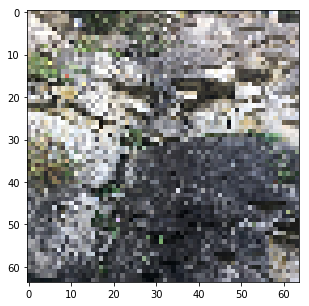

In [15]:
plt.rcParams['figure.figsize'] = 5, 5
temp = image.load_img('dataset_2/test_set/test_r2/IMG_3582.jpg', target_size = (im_dim, im_dim))
plt.imshow(temp, cmap='gray')

In [16]:
# plt.rcParams['figure.figsize'] = 10, 30
# plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# temp = image.load_img('model_plot.png')
# plt.imshow(temp)

In [17]:
classifier.fit_generator(training_set,
                         steps_per_epoch = 100,
                         epochs = 6,
                         validation_data = validation_set,
                         validation_steps = 20)

Epoch 1/6
100/100 [==============================] - 196s 2s/step - loss: 1.2678 - acc: 0.5950 - val_loss: 1.0194 - val_acc: 0.9331
Epoch 2/6
100/100 [==============================] - 174s 2s/step - loss: 0.6959 - acc: 0.9430 - val_loss: 0.3613 - val_acc: 0.9916
Epoch 3/6
100/100 [==============================] - 174s 2s/step - loss: 0.2527 - acc: 0.9920 - val_loss: 0.1426 - val_acc: 0.9916
Epoch 4/6
100/100 [==============================] - 175s 2s/step - loss: 0.1191 - acc: 0.9890 - val_loss: 0.0658 - val_acc: 1.0000
Epoch 5/6
100/100 [==============================] - 177s 2s/step - loss: 0.0679 - acc: 0.9910 - val_loss: 0.0416 - val_acc: 0.9958
Epoch 6/6
100/100 [==============================] - 188s 2s/step - loss: 0.0515 - acc: 0.9910 - val_loss: 0.0258 - val_acc: 1.0000


## Testing the network 

In [18]:
data_foulder = 'dataset_2'

import os
import numpy as np
from keras.preprocessing import image

def change_label(label):
    if label == 0:
        return 1
    elif label == 1:
        return 2
    elif label == 2:
        return 3
    elif label == 3:
        return 5

routes = ['r1', 'r2', 'r3', 'r5']
count_wrong = 0
count_right = 0
missclass_2=[]
for route in routes:

    test_images =  os.listdir(data_foulder + '/test_set/test_'+route)

    for img in test_images:
        
        if img != '.DS_Store':
        
            test_image = image.load_img(data_foulder+'/test_set/test_'+route+'/'+img,target_size = (im_dim, im_dim))
            test_image = image.img_to_array(test_image)
            test_image = avg_norm(np.expand_dims(test_image, axis = 0))
            result = change_label(np.argmax(classifier.predict(test_image)))
        
            if int(route[-1:]) != result:
                count_wrong +=1
                print (int(route[-1:]), result, data_foulder+'/test_set/test_'+route+'/'+img)
                missclass_2.append(data_foulder+'/test_set/test_'+route+'/'+img)
                
            else:
                count_right +=1
            
print 1-float(count_wrong)/(count_right+count_wrong)

(2, 3, 'dataset_2/test_set/test_r2/IMG_3551.jpg')
(2, 3, 'dataset_2/test_set/test_r2/IMG_3586.jpg')
(2, 3, 'dataset_2/test_set/test_r2/IMG_3552.jpg')
(2, 3, 'dataset_2/test_set/test_r2/IMG_3577.jpg')
0.985559566787


In [19]:
data_foulder = 'dataset'

routes = ['r1', 'r2', 'r3', 'r5']
count_wrong = 0
count_right = 0
missclass=[]
for route in routes:

    test_images =  os.listdir(data_foulder + '/test_set/test_'+route)

    for img in test_images:
        
        if img != '.DS_Store':
        
            test_image = image.load_img(data_foulder+'/test_set/test_'+route+'/'+img,target_size = (im_dim, im_dim))
            test_image = image.img_to_array(test_image)
            test_image = avg_norm(np.expand_dims(test_image, axis = 0))
            result = change_label(np.argmax(classifier.predict(test_image)))
        
            if int(route[-1:]) != result:
                count_wrong +=1
                print (int(route[-1:]), result, data_foulder+'/test_set/test_'+route+'/'+img)
                missclass.append(data_foulder+'/test_set/test_'+route+'/'+img)
                
            else:
                count_right +=1
            
print 1-float(count_wrong)/(count_right+count_wrong)

(2, 5, 'dataset/test_set/test_r2/te_r2_3.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_1.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_0.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_5.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_7.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_6.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_21.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_20.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_22.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_23.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_14.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_16.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_12.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_13.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_11.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_10.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_8.jpg')
(2, 5, 'dataset/test_set/test_r2/te_r2_9.jpg')
(3, 2, 'dataset/test_set/test_r3/te_r3_16.jpg')
(3, 2, 'dataset/test_set/test_r3/te_r3_17.jpg')
(3, 2, 'dataset/test_set/test_r3/te_r3_4.jpg')
(

# Analysis of results

# Conclusions and future work